# dinosaur-naming (Character-level Language Model)

Here we build a character-level language model for generating potential Dinosaur names.

> Inspired by: [Sequence Models](https://www.coursera.org/learn/nlp-sequence-models).

In [1]:
import numpy as np
import torch
from utils import rnn
import random
from tqdm import tqdm
from matplotlib import pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"PyTorch using device: {device}")

import importlib
_ = importlib.reload(rnn)

PyTorch using device: cuda


In [2]:
data = open('../data/dino-names.txt', 'r').read()
data = data.lower()
words = data.split('\n')
chars = sorted(list(set(data)))
data_size, vocab_size = len(data), len(chars)

print(f"[Train] word-count: {len(words)}")
print(f"[Train] total character-count: {len(data)}")
print(f"[Train] character-count: {len(chars)}\n\tCharacters: {chars}")

[Train] word-count: 1536
[Train] total character-count: 19909
[Train] character-count: 27
	Characters: ['\n', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## # pre-processing data
Here, will encode each character in the input as a one-hot vector.

In [3]:
ch_idx = dict()
idx_ch = dict()
for idx, ch in enumerate(chars):
    ch_idx[ch] = idx
    idx_ch[idx] = ch

n_x = vocab_size
I = np.eye(N=n_x)

X, Y = list(), list()
start_x = torch.zeros(size=(1,1,n_x,1))
eof_vector = torch.reshape(
    torch.Tensor(np.copy(I[[ch_idx['\n']]])), 
    shape=(1,1,n_x,1))
for w in words:
    char_idx = [ch_idx[c] for c in w]
    word_tensor = torch.reshape(
        torch.Tensor(np.copy(I[char_idx])), 
        shape=(len(w),1,n_x,1))
    
    # shape -> (T_x := len(w) + 1, 1, n_x, 1)
    X.append(torch.cat([start_x, word_tensor], dim=0))

    # shape -> (T_y := len(w) + 1, 1, n_x, 1)
    Y.append(torch.cat([word_tensor, eof_vector], dim=0))

print(f"[One-Hot] word-count: {len(X)}")

[One-Hot] word-count: 1536


## # forward-propagation

> **Note**: for forward propagation equations, see Section-2 of [`.\backprop-vanilla-rnn.pdf`](./backprop-vanilla-rnn.pdf)

In [4]:
def forward_prop(x: torch.Tensor, rnn_block: rnn.RNNBlock, a_0: torch.Tensor, **kwargs) -> dict:
    """Performs forward propagation through the specified rnn_block

    x: shape -> (T_x,m,n_x,1)
    rnn_block: an instance of RNNBlock()
    a_0: shape -> (n_a,1) or (m,n_a,1)

    output: a dictionary of activations for each time-step. This takes the following format
    cache[t] = {self.zy: z_y, self.za: z_a, self.at: a_t, self.yht: y_hat}
    """
    T_x, _, n_x, _ = x.shape
    cache = dict()
    a_t_1 = a_0
    for t in np.arange(start=1, stop=T_x+1):
        _, _, fw_cache = rnn_block.forward(a_t_1=a_t_1, x_t=x[t-1])

        a_t_1 = fw_cache[rnn_block.a_t]

        cache[t] = fw_cache

    return cache

def compute_loss(rnn_block: rnn.RNNBlock, forward_cache: dict, Y: torch.Tensor, 
        device=device, **kwargs) -> np.float64:
    T_x = Y.shape[0]
    m = Y.shape[1]

    loss = torch.zeros(size=(m,1), device=device)
    for t in np.arange(start=1,stop=T_x+1):
        cache = forward_cache[t]
        y_t = cache[rnn_block.yh_t]
        loss += torch.sum(torch.multiply(-Y[t-1, :, :, :], torch.log(y_t)), dim=1)

    return torch.mean(loss, dim=0, keepdim=False).item()

## # backward-propagation
> **Note:** for the backward-propagation equations, and their derivations, see Section-3 of [`.\backprop-vanilla-rnn.pdf`](./backprop-vanilla-rnn.pdf)

In [5]:
def backward_prop(Y: torch.Tensor, forward_cache: dict, 
        rnn_block: rnn.RNNBlock, da_Tx: torch.Tensor, **kwargs) -> dict:
    """Performs backward propagation through the specified rnn_block

    Y -> (T_x,m,n_y,1): the tensor of output labels 
    forward_cache: a dictionary containing the forward propagation cache as returned 
        by the `forward_prop()` method.
    rnn_block: an instance of RNNBlock()
    da_Tx: gradient for activation of the last time-step. Usually, this is a zero-vector.

    output: a dictionary of gradients for each time step.
    """
    T_x = Y.shape[0]

    cache = dict()
    da_t = da_Tx
    for t in np.arange(start=T_x, stop=0, step=-1):
        y, yh = Y[t-1,:,:,:], forward_cache[t][rnn_block.yh_t]
        dy_t = torch.transpose(torch.divide(input=y, other=yh), dim0=1, dim1=2)
        _, back_cache = rnn_block.backward(
            da_t=da_t, dy_t=dy_t, forward_cache_t=forward_cache[t], **kwargs)

        da_t = back_cache[rnn_block.da_t_1]

        cache[t] = back_cache

    return cache

## # model-training

We will use stochastic gradient descent for updating the parameters.

In [6]:
last_grad_params = None
def update_parameters(backward_cache: dict, rnn_block: rnn.RNNBlock, 
        iteration: int, epsilon: np.float64=1e-8, alpha: float=1e-3, 
        beta1: float=0.9, beta2: float=0.999, 
        limits=(None, None), **kwargs):
    """Updates the parameters of the model stored in the specified RNN-Block.

    backward_cache: the backward cache returned by the call to backward_prop()
    rnn_block: the RNN block containing the model being trained
    iteration: the iteration at which this method is called

    Note: other parameters have their usual meaning
    """

    global last_grad_params
    model = rnn_block.model
    params = {
        rnn_block.p_Waa: rnn_block.dW_aa, 
        rnn_block.p_Wax: rnn_block.dW_ax, 
        rnn_block.p_Wya: rnn_block.dW_ya, 
        rnn_block.p_by: rnn_block.db_y, 
        rnn_block.p_ba: rnn_block.db_a
    }

    if last_grad_params is None:
        last_grad_params = dict()
        for p, dp in params.items():
            last_grad_params['v-' + p] = torch.zeros_like(model[p])
            last_grad_params['s-' + p] = torch.zeros_like(model[p])

    gradients = {dp: torch.zeros_like(model[p]) for p, dp in params.items()}
    for t in range(1, len(backward_cache) + 1):
        back_cache = backward_cache[t]
        for p, dp in params.items():
            gradients[dp] += torch.mean(torch.transpose(
                    back_cache[dp], dim0=1, dim1=2), dim=0, keepdim=False)

    for p, dp in params.items():
        last_grad_params['v-' + p] = (1 - beta1) * gradients[dp] \
            + beta1 * last_grad_params['v-' + p]

    for p, dp in params.items():
        last_grad_params['s-' + p] = (1 - beta2) * torch.square(gradients[dp]) \
            + beta2 * last_grad_params['s-' + p]

    for p, dp in params.items():
        model[p] += -alpha * torch.divide(
            last_grad_params['v-' + p] / (1 - np.power(beta1, iteration)), 
            torch.sqrt(last_grad_params['s-' + p] / (1 - np.power(beta2, iteration))) 
                + epsilon)

def train(rnn_block: rnn.RNNBlock, X_train: list, Y_train: list, a_0: torch.Tensor, 
        da_Tx: torch.Tensor, epochs: int=100, **kwargs):
    """This method trains the RNN model.

    rnn_block: the rnn-block containing the model
    X_train: the list of training examples
    eof_vector -> (1,1,n_x,1): the one-hot encoding for `\n` character.
    epochs: the number of epochs
    """
    debug_cache = dict()

    iteration = 1
    train_set = list(zip(X_train, Y_train))
    for e in tqdm(np.arange(stop=epochs)):
        random.shuffle(train_set)
        for x, y in train_set:
            assert x.shape[0] == y.shape[0], \
                f"The input ({x.shape[0]}) and lable ({y.shape[0]}) lengths don't match."

            x_cuda, y_cuda = x.to(device=device), y.to(device=device)
            a_0_cuda, da_Tx_cuda = a_0.to(device=device), da_Tx.to(device=device)

            fw_cache = forward_prop(x=x_cuda, rnn_block=rnn_block, 
                a_0=a_0_cuda, **kwargs)

            bw_cache = backward_prop(
                Y=y_cuda, forward_cache=fw_cache, rnn_block=rnn_block, 
                da_Tx=da_Tx_cuda, **kwargs)

            update_parameters(backward_cache=bw_cache, rnn_block=rnn_block, 
                iteration=iteration, **kwargs)

            debug_cache[iteration] = compute_loss(
                rnn_block=rnn_block, forward_cache=fw_cache, Y=y_cuda, **kwargs)

            iteration += 1

    return rnn_block, debug_cache

## # model-training
The model parameters have the following dimensions:

<center>

| Parameter | Value | Remarks             |
|-----------|-------|---------------------|
| $n_x$     | 27    | the character-count |
| $n_a$     | 50    |                     |
| $n_y$     | 27    | the character-count |

</center>

In [7]:
rnn_block = rnn.Vanilla(model={
    'n_a': 50,
    'n_x': 27,
    'n_y': 27
})
model = rnn_block.model

model[rnn_block.p_Waa] = torch.empty(size=(model['n_a'], model['n_a']), device=device)
model[rnn_block.p_Waa] = torch.nn.init.xavier_normal_(model[rnn_block.p_Waa]) * 0.01

model[rnn_block.p_Wax] = torch.empty(size=(model['n_x'], model['n_a']), device=device)
model[rnn_block.p_Wax] = torch.nn.init.xavier_normal_(model[rnn_block.p_Wax]) * 0.01

model[rnn_block.p_Wya] = torch.empty(size=(model['n_a'], model['n_y']), device=device)
model[rnn_block.p_Wya] = torch.nn.init.xavier_normal_(model[rnn_block.p_Wya]) * 0.01

model[rnn_block.p_ba] = torch.empty(size=(model['n_a'],1), device=device)
_ = torch.nn.init.zeros_(model[rnn_block.p_ba])

model[rnn_block.p_by] = torch.empty(size=(model['n_y'],1), device=device)
_ = torch.nn.init.zeros_(model[rnn_block.p_by])

In [8]:
a_0 = torch.zeros(size=(1,model['n_a'],1))
da_Tx = torch.zeros(size=(1,1,model['n_a']))

_, debug_cache = train(rnn_block=rnn_block, X_train=X, Y_train=Y, a_0=a_0, da_Tx=da_Tx,
    eof_vector=eof_vector, epochs=25, alpha=1e-5, device=device)

100%|██████████| 25/25 [10:09<00:00, 24.38s/it]


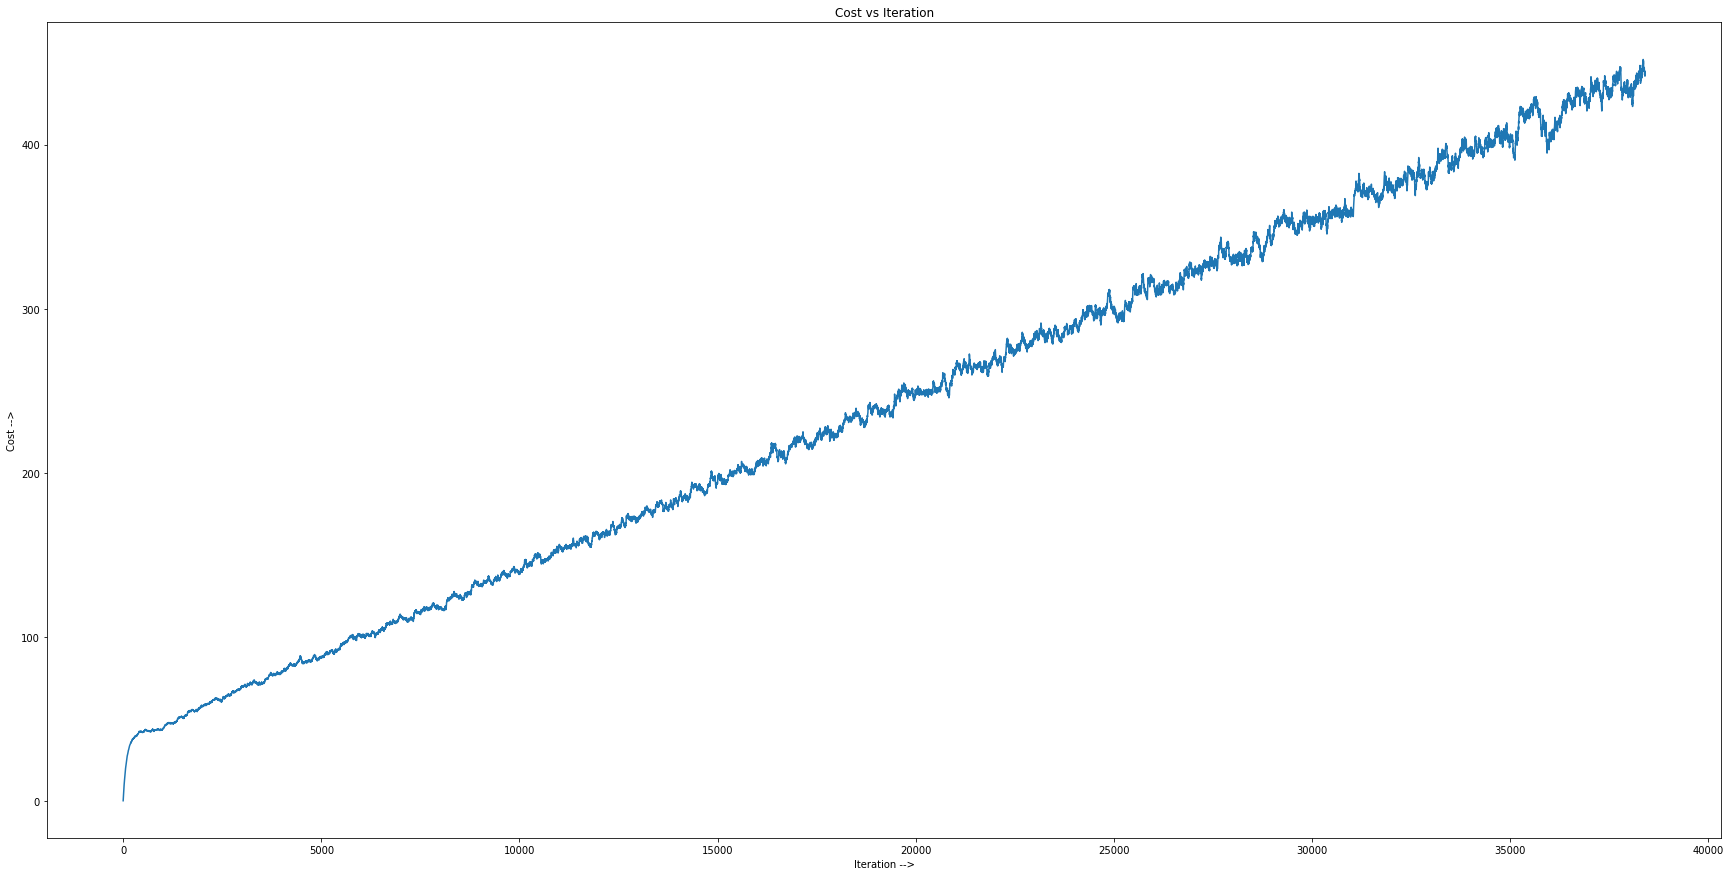

In [9]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(30,15))

x = list(debug_cache.keys())
y = list(debug_cache.values())
ewma_y = list()

beta = 0.99
v_1 = 0
for i,v in zip(x,y):
    ewma_y.append((1-beta) * v + beta * v_1)
    v_1 = ewma_y[-1]

ax.plot(x, ewma_y)
ax.set_xlabel('Iteration -->')
ax.set_ylabel('Cost -->')
ax.set_title('Cost vs Iteration')

plt.show()

## # sampling
Here we sample characters to produce potential dinosaur names. Instead of sampling the most probable word, based on the probabilities from the output vector $\hat{\mathbf{y}}^{\langle t\rangle}$, we choose a random-word based on this probability distribution. Since, if we chose the most probable word, the model will sample the same word all the time.

In [10]:
model = rnn_block.model

is_eof_char = False
a_t_1 = a_0
x_t = start_x[0,:,:,:]
word = list()
while (not is_eof_char) and (len(word) <= 50):
    y_hat, a_t, c = rnn_block.forward(
        a_t_1=a_t_1.to(device), x_t=x_t.to(device))
    idx = np.random.choice(a=list(idx_ch.keys()), 
        p=torch.squeeze(input=y_hat).cpu().detach().numpy())

    is_eof_char = idx == 0

    word.append(idx_ch[idx])
    x_t = torch.reshape(torch.Tensor(np.copy(I[idx])), 
        shape=(1,n_x,1))
    a_t_1 = a_t

print(f"Sample word: {''.join(word)}")

Sample word: wzfwwfvzqfzqqqfwbxvjffqjwjfffwxjjzwqfzzjqqzwxqjbvjw
